# **What is LlamaIndex?**
LlamaIndex (formerly GPT Index) is an open-source framework that helps you connect large language models (LLMs) like GPT to your own data — especially unstructured documents like PDFs, HTML, Markdown, etc.

It essentially acts as a middleware between your data and an LLM, helping you:

**Ingest, index, and query data.**

Build complex retrieval systems over large collections of documents.

Use structured techniques like query decomposition (e.g., sub-question engines) and retrieval-augmented generation (RAG).


🧠 **Sub Question Query Engine in LlamaIndex**

In the context of 10-K filings over multiple years, a SubQuestionQueryEngine helps break down a complex question into multiple simpler sub-questions, which are independently answered using the appropriate documents (e.g., a specific year’s 10-K), and then the answers are synthesized into one coherent response.

**Example:**

🔹 Main Question: How has the company’s R&D spending changed over the last 4 years?

**The engine would:**

Break it into sub-questions like:

What was the R&D spending in 2021?

What was the R&D spending in 2022?

..........................................................

Query each year’s 10-K individually.

Combine the answers into a synthesized response (e.g., trend analysis).

🧰 **Why Use It?**

*   Enables temporal or comparative analysis across years.
*   Ideal for structured data inside long, unstructured documents.
*   Avoids overwhelming the LLM with too much context at once.



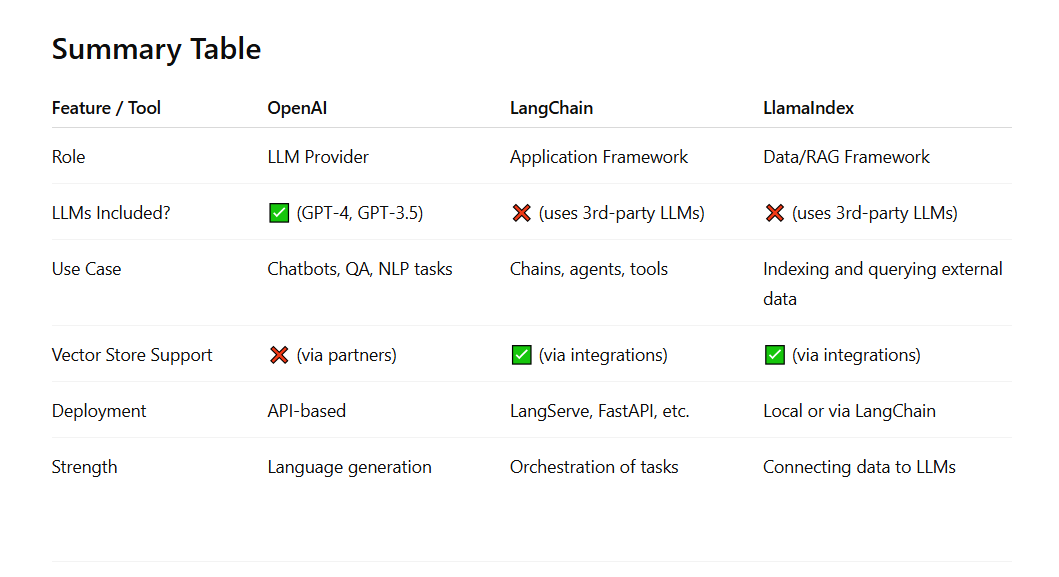

# How to Build a Chatbot

LlamaIndex serves as a bridge between your data and Language Learning Models (LLMs), providing a toolkit that enables you to establish a query interface around your data for a variety of tasks, such as question-answering and summarization.

In this tutorial, we'll walk you through building a context-augmented chatbot using a [Data Agent](https://gpt-index.readthedocs.io/en/stable/core_modules/agent_modules/agents/root.html). This agent, powered by LLMs, is capable of intelligently executing tasks over your data. The end result is a chatbot agent equipped with a robust set of data interface tools provided by LlamaIndex to answer queries about your data.

**Note**: This tutorial builds upon initial work on creating a query interface over SEC 10-K filings - [check it out here](https://medium.com/@jerryjliu98/how-unstructured-and-llamaindex-can-help-bring-the-power-of-llms-to-your-own-data-3657d063e30d).

### Context

In this guide, we’ll build a "10-K Chatbot" that uses raw UBER 10-K HTML filings from Dropbox. Users can interact with the chatbot to ask questions related to the 10-K filings.

# **✅ 10-K Documents vs 10-K Filings**
📄 **10-K Documents**

These refer to the actual content of a company’s annual report filed with the SEC (U.S. Securities and Exchange Commission). A 10-K document includes:

Business overview

Risk factors

Financial statements

Management discussion and analysis (MD&A)

Notes to financials

And more...

So, when we say “10-K documents”, we’re often referring to the actual PDF, HTML, or text version containing all the information.

📝 **10-K Filings**

This term refers more broadly to the act and record of submitting the 10-K document to the SEC. A filing is the legal submission (via the EDGAR system) and includes:

Metadata (filing date, accession number, etc.)

All supporting documents (not just the main 10-K — could include exhibits, signatures, etc.)

A historical trace in the official regulatory record

In simple terms:


**Term	What it Focuses On**

10-K Document	The actual report content (text, tables, etc.)
10-K Filing	The official submission to the SEC (includes metadata, versioning, and attachments)

### Preparation

In [1]:
%pip install llama-index-readers-file
%pip install llama-index-embeddings-openai
%pip install llama-index-agent-openai
%pip install llama-index-llms-openai
%pip install llama-index-question-gen-openai
%pip install unstructured

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 965.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.4/189.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━

In [ ]:
# import os

# os.environ["OPENAI_API_KEY"] = "sk-..."

# from google.colab import userdata
# userdata.get('OPENAI_API_KEY')

In [2]:
import os
from google.colab import userdata
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

# global defaults
Settings.llm = OpenAI(model="gpt-4o-mini")
Settings.embed_model = OpenAIEmbedding(model_name="text-embedding-3-large")
Settings.chunk_size = 512
Settings.chunk_overlap = 64

### Ingest Data

Let's first download the raw 10-k files, from 2019-2022.

In [3]:
# NOTE: the code examples assume you're operating within a Jupyter notebook.
# download files
!mkdir data
!wget "https://www.dropbox.com/s/948jr9cfs7fgj99/UBER.zip?dl=1" -O data/UBER.zip
!unzip data/UBER.zip -d data

--2025-05-05 15:19:52--  https://www.dropbox.com/s/948jr9cfs7fgj99/UBER.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/vetj6tgcux8e309swquxs/UBER.zip?rlkey=oy4vx60rplorounkh9wh2waux&dl=1 [following]
--2025-05-05 15:19:52--  https://www.dropbox.com/scl/fi/vetj6tgcux8e309swquxs/UBER.zip?rlkey=oy4vx60rplorounkh9wh2waux&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2672a1452765df84036ab5a882.dl.dropboxusercontent.com/cd/0/inline/CpEfbnaiNYLpTTNRAcdtJtfji0pmvgnjvElK5vuLkAguqSmTiYpxOolHzj58ikeft7i5ncgeYwyHlODLIH9FQotLMpOGJZ_ScX1faHSPq9Q-EsQAgh7_-z0zPgyPuvxsDj4/file?dl=1# [following]
--2025-05-05 15:19:52--  https://uc2672a1452765df84036ab5a882.dl.dropboxusercontent.com/cd/0/inline/CpEfbnaiNYLpTT

To parse the HTML files into formatted text, we use the [Unstructured](https://github.com/Unstructured-IO/unstructured) library. Thanks to [LlamaHub](https://llamahub.ai/), we can directly integrate with Unstructured, allowing conversion of any text into a Document format that LlamaIndex can ingest.

First we install the necessary packages:

Then we can use the `UnstructuredReader` to parse the HTML files into a list of `Document` objects.

In [4]:
from llama_index.readers.file import UnstructuredReader
from pathlib import Path

#years = [2022, 2021, 2020, 2019]
years = [2019,2021]

In [5]:
loader = UnstructuredReader()
doc_set = {}
all_docs = []
for year in years:
    year_docs = loader.load_data(
        file=Path(f"./data/UBER/UBER_{year}.html"), split_documents=False
    )
    # insert year metadata into each year
    for d in year_docs:
        d.metadata = {"year": year}
    doc_set[year] = year_docs
    all_docs.extend(year_docs)

In [6]:
all_docs

[Document(id_='UBER_2019.html', embedding=None, metadata={'year': 2019}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='UNITED STATES\n\nSECURITIES AND EXCHANGE COMMISSION\n\nWashington, D.C. 20549\n\n____________________________________________\n\nFORM\n\n____________________________________________\n\n(Mark One)\n\nANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the fiscal year ended\n\nOR\n\nTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from_____ to _____\n\nCommission File Number:\n\n____________________________________________\n\n(Exact name of registrant as specified in its charter)\n\n____________________________________________\n\nDelaware 45-2647441 (State or other jurisdiction of incorporation or organizati

In [11]:
doc_set[2021]  #{year:record_of_that year.html}

[Document(id_='UBER_2021.html', embedding=None, metadata={'year': 2021}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text="UNITED STATES\n\nSECURITIES AND EXCHANGE COMMISSION\n\nWashington, D.C. 20549\n\n____________________________________________\n\nFORM\n\n____________________________________________\n\n(Mark One)\n\nANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the fiscal year ended\n\nOR\n\nTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from_____ to _____\n\nCommission File Number:\n\n____________________________________________\n\n(Exact name of registrant as specified in its charter)\n\n____________________________________________\n\nDelaware 45-2647441 (State or other jurisdiction of incorporation or organizati

### Setting up Vector Indices for each year

We first setup a vector index for each year. Each vector index allows us
to ask questions about the 10-K filing of a given year.

We build each index and save it to disk.

In [12]:
# initialize simple vector indices
# NOTE: don't run this cell if the indices are already loaded!
from llama_index.core import VectorStoreIndex, StorageContext


index_set = {}
for year in years:
    storage_context = StorageContext.from_defaults()
    cur_index = VectorStoreIndex.from_documents(
        doc_set[year],
        storage_context=storage_context,
    )
    index_set[year] = cur_index
    storage_context.persist(persist_dir=f"./storage/{year}")

To load an index from disk, do the following

In [13]:
# Load indices from disk
from llama_index.core import StorageContext, load_index_from_storage

index_set = {}
for year in years:
    storage_context = StorageContext.from_defaults(
        persist_dir=f"./storage/{year}"
    )
    cur_index = load_index_from_storage(
        storage_context,
    )
    index_set[year] = cur_index

### Setting up a Sub Question Query Engine to Synthesize Answers Across 10-K Filings

Since we have access to documents of 4 years, we may not only want to ask questions regarding the 10-K document of a given year, but ask questions that require analysis over all 10-K filings.

To address this, we can use a [Sub Question Query Engine](https://gpt-index.readthedocs.io/en/stable/examples/query_engine/sub_question_query_engine.html). It decomposes a query into subqueries, each answered by an individual vector index, and synthesizes the results to answer the overall query.

LlamaIndex provides some wrappers around indices (and query engines) so that they can be used by query engines and agents. First we define a `QueryEngineTool` for each vector index.
Each tool has a name and a description; these are what the LLM agent sees to decide which tool to choose.

In [14]:
from llama_index.core.tools import QueryEngineTool

individual_query_engine_tools = [
    QueryEngineTool.from_defaults(
        query_engine=index_set[year].as_query_engine(),
        name=f"vector_index_{year}",
        description=(
            "useful for when you want to answer queries about the"
            f" {year} SEC 10-K for Uber"
        ),
    )
    for year in years
]

Now we can create the Sub Question Query Engine, which will allow us to synthesize answers across the 10-K filings. We pass in the `individual_query_engine_tools` we defined above.

In [17]:
from llama_index.core.query_engine import SubQuestionQueryEngine

query_engine = SubQuestionQueryEngine.from_defaults(
    query_engine_tools=individual_query_engine_tools,
)

### Setting up the Chatbot Agent

We use a LlamaIndex Data Agent to setup the outer chatbot agent, which has access to a set of Tools. Specifically, we will use an OpenAIAgent, that takes advantage of OpenAI API function calling. We want to use the separate Tools we defined previously for each index (corresponding to a given year), as well as a tool for the sub question query engine we defined above.

First we define a `QueryEngineTool` for the sub question query engine:

In [18]:
query_engine_tool = QueryEngineTool.from_defaults(
    query_engine=query_engine,
    name="sub_question_query_engine",
    description=(
        "useful for when you want to answer queries that require analyzing"
        " multiple SEC 10-K documents for Uber"
    ),
)

Then, we combine the Tools we defined above into a single list of tools for the agent:

In [19]:
tools = individual_query_engine_tools + [query_engine_tool]

Finally, we call `FunctionAgent` to create the agent, passing in the list of tools we defined above.

In [20]:
from llama_index.core.agent.workflow import FunctionAgent
from llama_index.llms.openai import OpenAI

agent = FunctionAgent(tools=tools, llm=OpenAI(model="gpt-4o-mini"))

### Testing the Agent

We can now test the agent with various queries.

If we test it with a simple "hello" query, the agent does not use any Tools.

In [21]:
from llama_index.core.workflow import Context

# Setup the context for this specific interaction
ctx = Context(agent)

response = await agent.run("hi, i am bob", ctx=ctx)
print(str(response))

Hello Bob! How can I assist you today?


If we test it with a query regarding the 10-k of a given year, the agent will use
the relevant vector index Tool.

In [22]:
response = await agent.run(
    "What were some of the biggest risk factors in 2019 for Uber?", ctx=ctx
)
print(str(response))

In 2019, some of the biggest risk factors for Uber included:

1. **Intense Competition**: Uber faced significant competition in the personal mobility, meal delivery, and logistics industries.
2. **Economic Conditions**: Adverse economic conditions could impact the number of drivers on the platform.
3. **Cost Increases**: Rising costs related to fuel, food, labor, and other operational expenses could negatively affect operating results.
4. **Capital Needs**: The need for additional capital to support business growth posed a risk.
5. **Security Breaches**: There was a risk of security breaches or unauthorized access to sensitive data, which could lead to revenue loss and harm to the brand.

If you have any more questions or need further details, feel free to ask!


Finally, if we test it with a query to compare/contrast risk factors across years, the agent will use the Sub Question Query Engine Tool.

In [23]:
cross_query_str = (
    "Compare/contrast the risk factors described in the Uber 10-K across"
    " years. Give answer in bullet points."
)

response = await agent.run(cross_query_str, ctx=ctx)
print(str(response))

Here’s a comparison of the risk factors described in Uber's 10-K filings for 2019 and 2021:

### 2019 Risk Factors:
- **Intense Competition**: Highly competitive personal mobility, meal delivery, and logistics industries with established, low-cost alternatives.
- **Low Barriers to Entry**: New competitors can easily enter the market, increasing competition.
- **Low Switching Costs**: Customers can easily switch to other services, impacting customer retention.
- **Well-Capitalized Competitors**: Competitors in major geographic regions are often well-funded, posing a threat to Uber's market share.

### 2021 Risk Factors:
- **Privacy and Cybersecurity Risks**: Increased challenges related to privacy, cybersecurity, and fraud, especially with remote working.
- **Legal and Regulatory Challenges**: Evolving legal guidance related to the COVID-19 pandemic created new regulatory challenges.
- **Financial Impacts from COVID-19**: The pandemic affected both near-term and long-term financial resu

In [24]:
cross_query_str = (
    "What is the problem with OLA"
)

response = await agent.run(cross_query_str, ctx=ctx)
print(str(response))

Generated 2 sub questions.
[vector_index_2019] Q: What are the key financial metrics in the 2019 SEC 10-K for Uber?
[vector_index_2021] Q: What are the key financial metrics in the 2021 SEC 10-K for Uber?
[vector_index_2019] A: Key financial metrics in the 2019 SEC 10-K for Uber include Monthly Active Platform Consumers (MAPCs), Trips, Gross Bookings, Revenue, Adjusted Net Revenue, Net income (loss) attributable to Uber Technologies, Inc., Loss from operations, Interest expense, and Net cash used in operating activities, investing activities, and financing activities.
[vector_index_2021] A: Key financial metrics in the 2021 SEC 10-K for Uber include Monthly Active Platform Consumers (MAPCs), Trips, Gross Bookings, Revenue, Net loss attributable to Uber Technologies, Inc., Mobility Adjusted EBITDA, Delivery Adjusted EBITDA, and Adjusted EBITDA.
It seems that there isn't specific information available regarding the problems with OLA in the context of Uber's SEC 10-K reports for 2019 and 

### Setting up the Chatbot Loop

Now that we have the chatbot setup, it only takes a few more steps to setup a basic interactive loop to chat with our SEC-augmented chatbot!

In [25]:
agent = FunctionAgent(tools=tools, llm=OpenAI(model="gpt-4o"))
ctx = Context(agent)

while True:
    text_input = input("User: ")
    if text_input == "exit":
        break
    response = await agent.run(text_input, ctx=ctx)
    print(f"Agent: {response}")

# User: What were some of the legal proceedings against Uber in 2022?

User: How many years data we have?
Agent: We have data for the years 2019 and 2021 from the SEC 10-K filings for Uber.
User: Who is OLA
Agent: Ola is a ride-sharing company based in India. It was founded in December 2010 by Bhavish Aggarwal and Ankit Bhati. Ola operates as a mobile app-based transportation network company, offering services similar to those of Uber. It provides a platform for users to book rides from a variety of vehicle options, including cars, auto-rickshaws, and bikes, among others. Ola has expanded its services beyond India to several other countries and has diversified its offerings to include food delivery and financial services.
User: Do we any record present with respect to OLA?
Agent: In the 2019 SEC 10-K filing for Uber, there is no mention of Ola. However, in the 2021 SEC 10-K filing, Ola is mentioned as a ridesharing company that competes with other ridesharing companies like Lyft, Didi, Grab, and Bolt.
User: exit
